In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table
import os
import numpy as np
# import cartopy.crs as ccrs
import json
import os
import seaborn as sns
from astropy.table import Table

In [2]:
os.chdir('/home/walml/repos/zoobot')

Pretend this is the final decals catalog

In [3]:
# latest_export = pd.read_csv('/media/walml/beta/galaxy_zoo/decals/dr5/volunteer_reduction/2020_11_10_tobias/output/classifications_final.csv')  # Tobias offline aggregated classifications

In [4]:
latest_export = pd.read_parquet('/home/walml/repos/gz-panoptes-reduction/temp/latest_aggregated.parquet')

In [5]:
latest_export

,iauname,bar_no,bar_strong,bar_weak,bulge-size_dominant,bulge-size_large,bulge-size_moderate,bulge-size_none,bulge-size_small,disk-edge-on_no,...,bulge-size_moderate_fraction,bulge-size_large_fraction,bulge-size_dominant_fraction,merging_merger_fraction,merging_tidal-debris-v1_fraction,merging_both-v1_fraction,merging_neither-v1_fraction,merging_major-disturbance_fraction,merging_minor-disturbance_fraction,merging_none_fraction
0,J112953.88-000427.4,13,2,1,1,6,9,0,0,16,...,0.562500,0.375,0.0625,0.0,0.0,0.0,0.0,0.0625,0.100,0.8375
1,J104325.29+190335.0,2,0,0,1,0,1,0,0,2,...,0.500000,0.000,0.5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,J104629.54+115415.1,2,0,2,0,0,2,0,2,4,...,0.500000,0.000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.200,0.8000
3,J082950.68+125621.8,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0000,0.125,0.8750
4,J122056.00-015022.0,3,0,0,0,0,2,0,1,3,...,0.666667,0.000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265833,J144017.17+234347.3,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265834,J133751.46+253954.0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0000,0.000,1.0000
265835,J130734.26+061155.7,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0000,0.000,1.0000
265836,J163830.70+315116.7,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
pd.isna(latest_export['iauname']).sum() # all galaxies with no iauname are grouped! Including EAGLE

1

In [7]:
latest_export[pd.isna(latest_export['iauname'])].squeeze()

iauname                                   None
bar_no                                  109827
bar_strong                               18003
bar_weak                                 33480
bulge-size_dominant                      13439
                                        ...   
merging_both-v1_fraction                     0
merging_neither-v1_fraction                  0
merging_major-disturbance_fraction    0.143465
merging_minor-disturbance_fraction    0.210717
merging_none_fraction                 0.605108
Name: 56368, Length: 85, dtype: object

In [8]:
latest_export = latest_export.dropna(subset=['iauname'])

In [9]:
to_upload = Table.read('/media/walml/beta/galaxy_zoo/decals/catalogs/dr5_nsa1_0_0_to_upload.fits').to_pandas()  # joint catalog, after selection cuts
to_upload['iauname'] = to_upload['iauname'].str.decode('utf8')

In [10]:
# correct these paths, in case useful in the final uploadable catalog
to_upload = to_upload.rename(index=str, columns={
    'fits_loc': 'local_fits_loc',
    'png_loc': 'local_png_loc'
})
to_upload['png_loc'] = to_upload['local_png_loc'].str.decode('utf-8')
to_upload['png_loc'] = to_upload['png_loc'].str.replace('/Volumes/EXTERNAL/decals/png/', 'png_native/')

In [11]:
# to_upload.query('fits_filled').to_csv('dr5_with_fits_filled.csv', index=False)  # all galaxies with DR5 fits_filled (includes DR1/2 galaxies)

In [12]:
#dr1/2 raw classifications
dr1_c = pd.read_csv('/media/walml/beta/galaxy_zoo/decals/gzreduction_ouroborous/working_dir/raw/classifications/2017-10-15_galaxy_zoo_decals_classifications.csv')
dr2_c = pd.read_csv('/media/walml/beta/galaxy_zoo/decals/gzreduction_ouroborous/working_dir/raw/classifications/2017-10-15_galaxy_zoo_decals_dr2_classifications.csv')


## Remove galaxies with classifications that we shouldn't publish 

Because they don't have fits_filled

In [13]:
# and in decals, passed selection cuts, implicitly. Removes some test uploads, some of whcih have nan iaunames
good_images = latest_export['iauname'].isin(to_upload.query('fits_filled')['iauname'])  
good_images.value_counts()

True     253287
False     12550
Name: iauname, dtype: int64

In [14]:
bad_iaunames = set(latest_export[~good_images]['iauname'])
len(bad_iaunames)

12550

In [15]:
# # save for use in other projects, if needed - remember these are still in the flat tables
# with open('data/bad_iaunames.json', 'w') as f:
#     json.dump(list(bad_iaunames), f)

In [16]:
safe_export = latest_export[good_images]  # use good images going forward

### Check Retirement, Check Old Merger Votes are Excluded

In [17]:
(safe_export['smooth-or-featured_total-votes'] - safe_export['merging_total-votes'] ).value_counts()

0      132104
1       52652
2       18482
3        9259
4        6188
        ...  
74          1
73          1
185         1
71          1
99          1
Length: 92, dtype: int64

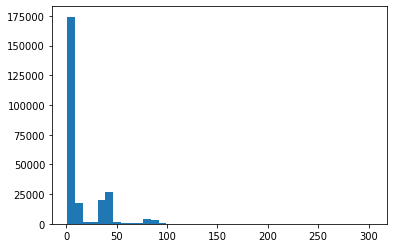

In [18]:
_ = plt.hist(safe_export['smooth-or-featured_total-votes'], bins=40)

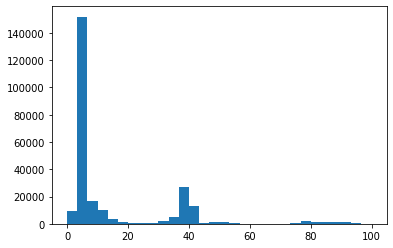

In [19]:
_, bins = np.histogram(np.linspace(0., 100), bins=30)
_ = plt.hist(safe_export['smooth-or-featured_total-votes'], bins=bins)

In [87]:
(safe_export['smooth-or-featured_total-votes'] > 40).sum(), (safe_export['smooth-or-featured_total-votes'] > 40).mean()

(14960, 0.05906343397016033)

In [20]:
(safe_export['smooth-or-featured_total-votes'] > 2).mean()  # 98% have 3 or more votes, good for ML

0.9853723246751709

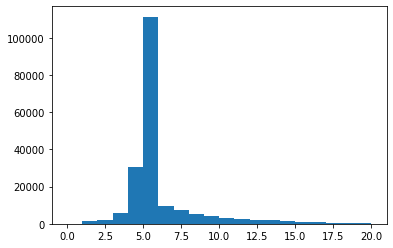

In [21]:
_, bins = np.histogram(np.linspace(0., 20), bins=20)
_ = plt.hist(safe_export['smooth-or-featured_total-votes'], bins=bins)

(0.0, 100)

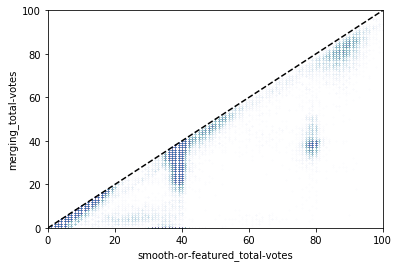

In [22]:
fig, ax = plt.subplots()
sns.scatterplot(safe_export['smooth-or-featured_total-votes'], safe_export['merging_total-votes'], ax=ax, alpha=.01, s=5.)
ax.plot([0., 100.], [0., 100.], 'k--')
ax.set_xlim([0., 100])
ax.set_ylim([0., 100])
# some galaxies (esp. at 40 or 80, the dr5 duplicates) have slightly fewer merger votes because the old votes are excluded. But NONE have MORE merger votes, which was an aggregation bug I found previously.

In [23]:
safe_export['merge_minus_smooth'] = safe_export['merging_total-votes'] - safe_export['smooth-or-featured_total-votes']

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
assert not any((safe_export['merge_minus_smooth'] > 0))  # should not be possible!

# Flag galaxies by origin

In [25]:
calibration_subject_sets = [
#     19829,  # nair 250 each  # superceded by below set
    19832  # nair all
]

pre_active_subject_sets = [
    20036,  # first 3k
    20156, # 3k-5k,
    20603,  # 5k
    21156, # 10k
    51756, # 3k
    60259,  # 5k
    60995, # +5k   
    67383,  # +15k,
    67382,  # +500
    74807  # decals classic mode subjects, going to include as 'pre-active'
]

targeted_observations = [
    20354, # yjan 790
    60258  # yjan 1100ish (id/date is a touch strange)
]

active_baseline = [74905, 85299, 87884, 88772]  # random, missing, missing_d, missing_e

active_priority = [74909]



# and will add the newly-found galaxies to active_baseline

In [26]:
set_namer = {
    'calibration_nair_dr2_dr5': calibration_subject_sets,
    'pre_active': pre_active_subject_sets,
    'targeted': targeted_observations,
    'active_baseline': active_baseline,
    'active_priority': active_priority
}

In [27]:
exclude = {
    16811,
    74894,
    83000,
    60988,
    83139,
    76070,
    78914,
    76288,
    19829,
    83000,
    83139,
    77652  # eagle
}

I need to check the vote distribution for active learning vs random. If it worked right, there should be more featured galaxies in priority set.

In [28]:
latest_subjects = pd.read_csv('/media/walml/beta/galaxy_zoo/decals/dr5/volunteer_reduction/2020_11_10_tobias/data/galaxy-zoo-subjects.csv')

In [29]:
latest_subjects = latest_subjects[~latest_subjects['subject_set_id'].isin(exclude)]

In [30]:
latest_subjects['workflow_id'] = latest_subjects['workflow_id'].fillna('inactive')

In [31]:
latest_subjects['workflow_id'].value_counts()

6122.0      230381
10582.0     209487
inactive     21504
10581.0       5765
11308.0       5000
6527.0        1601
5653.0         875
12410.0        150
16875.0         30
Name: workflow_id, dtype: int64

In [32]:
# latest_subjects[(latest_subjects['subject_set_id'] == int(74909))]

In [33]:
latest_subjects = latest_subjects[latest_subjects['workflow_id'].isin([6122.0, 10582.0, 10581.0, 'inactive'])]  # decals public workflows. 'inactive' to catch unchecked sets
latest_subjects['workflow_id'].value_counts()

6122.0      230381
10582.0     209487
inactive     21504
10581.0       5765
Name: workflow_id, dtype: int64

In [34]:
latest_subjects['subject_set_id'].value_counts()

74905    357026
85299     21900
67383     15000
87884     11456
74909     10048
21156     10000
88772      9074
74807      5765
60259      5000
60995      5000
20603      5000
20036      3000
51756      3000
20156      2000
19832      1601
60258       977
20354       790
67382       500
Name: subject_set_id, dtype: int64

In [35]:
latest_subjects['metadata'] = latest_subjects['metadata'].apply(json.loads)

In [36]:
def get_iauname(metadata):
    possible_keys = ['iauname', '!iauname', 'IAUNAME', '!IAUNAME']
    for key in possible_keys:
        if key in metadata.keys():
            return metadata[key]
    return np.nan

In [37]:
latest_subjects['iauname'] = latest_subjects['metadata'].apply(get_iauname)

In [38]:
assert not any(pd.isna(latest_subjects['iauname']))

In [39]:
latest_subjects['subject_set_id'].value_counts()

74905    357026
85299     21900
67383     15000
87884     11456
74909     10048
21156     10000
88772      9074
74807      5765
60259      5000
60995      5000
20603      5000
20036      3000
51756      3000
20156      2000
19832      1601
60258       977
20354       790
67382       500
Name: subject_set_id, dtype: int64

In [40]:
expected_sets = set(calibration_subject_sets + pre_active_subject_sets + targeted_observations + active_baseline + active_priority)
actual_sets = set(latest_subjects['subject_set_id'].unique())

In [41]:
actual_sets.difference(expected_sets)

set()

In [42]:
assert actual_sets.difference(expected_sets) == set()

In [43]:
# 74807 is an early active-learning-random upload, made just before turning active learning on, to the 'classic' (as opposed to enhanced) workflow
# they were pretty much all classified to N=100, probably because I hadn't yet got caesar working right on 'classic'
# about half of the galaxies (not subjects) are also in either pre-active-learning uploads or enhanced mode random uploads
# https://www.zooniverse.org/lab/5733/subject-sets/74807
# because they are random and highly classified, I list them in the data release as 'pre-active'

In [44]:
# classic_ids = latest_subjects.query('subject_set_id == "74807"')['subject_id']

In [45]:
# good_export = latest_export[good_images]
# good_export[good_export['subject_id'].isin(classic_ids)]['smooth-or-featured_total-votes'].hist(bins=40)

In [46]:
# latest_subjects.query('subject_set_id == "74807"')['metadata'].iloc[5]

In [47]:
# latest_subjects.query('subject_set_id == "74905"')['metadata'].iloc[0]

In [48]:
classic = latest_subjects.query('subject_set_id == "74807"')
in_both = classic[classic['iauname'].isin(latest_subjects.query('subject_set_id != "74807"')['iauname'])]
only_in_classic = classic[~classic['iauname'].isin(latest_subjects.query('subject_set_id != "74807"')['iauname'])]
len(classic), len(only_in_classic), len(in_both)

(5765, 3067, 2698)

In [49]:
latest_subjects[latest_subjects['iauname'].isin(in_both['iauname'])]['subject_set_id'].value_counts()  # which other subject sets are they in? random, (classic), a few active. Not calibration.

74905    5324
74807    2698
74909      67
Name: subject_set_id, dtype: int64

In [50]:
latest_subjects.query('subject_set_id == "74807"')['locations'].iloc[0]

'{"0":"https://panoptes-uploads.zooniverse.org/production/subject_location/51d32137-5405-4966-b01b-0e17035a86bc.png"}'

*Checking this way around is important!*

Subject sets not checked on any workflow will not be included in the export, and so those galaxies won't be marked as in that upload_group and may be dropped in the merges below.

In [51]:
expected_sets.difference(actual_sets)  # these have labels but are not actually included in the export.
# 19829 is a small calibration set superceded by nair_all. 
# 74909 is the active learning priority set though! What happened to those galaxies?!

set()

In [52]:
assert expected_sets.difference(actual_sets) == set()

### Name each set

In [53]:
def name_subject_set(subject_set_id):
    for key, ids in set_namer.items():
        if subject_set_id in ids:
            return key
    return 'failed'

In [54]:
latest_subjects['upload_group'] = latest_subjects['subject_set_id'].apply(lambda x: name_subject_set(int(x)))
latest_subjects['upload_group'].value_counts()

active_baseline             399456
pre_active                   54265
active_priority              10048
targeted                      1767
calibration_nair_dr2_dr5      1601
Name: upload_group, dtype: int64

In [55]:
latest_subjects.query('upload_group == "failed"')

,subject_id,project_id,workflow_id,subject_set_id,metadata,locations,classifications_count,retired_at,retirement_reason,created_at,updated_at,iauname,upload_group


In [56]:
# assigning galaxies (iaunames) into subject sets may be awkward due to duplicates - check how many are in several

In [57]:
t = latest_subjects.groupby('iauname').agg({'upload_group': lambda x: tuple(set(x))})

In [58]:
t['upload_group'].value_counts()

(active_baseline,)                                              203998
(pre_active,)                                                    48357
(active_priority, active_baseline)                                5058
(active_priority,)                                                2737
(pre_active, active_baseline)                                     2638
(targeted,)                                                       1430
(calibration_nair_dr2_dr5,)                                       1266
(targeted, pre_active)                                             198
(calibration_nair_dr2_dr5, targeted)                               139
(calibration_nair_dr2_dr5, active_baseline)                        136
(active_priority, calibration_nair_dr2_dr5)                         52
(active_priority, pre_active)                                       42
(active_priority, pre_active, active_baseline)                      28
(active_priority, calibration_nair_dr2_dr5, active_baseline)         8
Name: 

Good - mostly the duplicates are all within the same subject sets. Let's resolve as follows:
- active_priority + active_baseline = active_priority
- calibration = pre_active, because they were selected before active learning. Slight silent bias as they are brighter, but no way to avoid
- calibration + anything = anything, calibration is not a random subset so preserve anything's selection func
- targeted + anything = anything, would have been in anything either way
- pre_active + active_priority = pre_active (should not have been reclassified)
- active_baseline + pre_active = pre_active (should not have been reclassified)

In [59]:
def group_metadata(x):
    pass  # TODO

def group_locations(x):
    return json.dumps([json.loads(row)['0'] for row in x.values])  # list of unique urls, assuming 0 is the only key in each row

def group_upload_group(x):
    
    x = list(x)
    
    # only return calibration if that's the only set
#     if set(x) == set(['calibration_nair_dr2_dr5']):
#         return x.iloc[0]
# changed my mind - calibration will be flagged separately, and galaxies in and only in calibration are effectively early pre-active uploads
#     assert not x.empty
    assert x

    if 'calibration_nair_dr2_dr5' in x:  # calibration galaxy, already classified in DR2, would not have been reclassified
        return 'calibration'
    
    x_unique = set(x)
    if len(x_unique) == 1:  # just calibration or just one other subject set
        return list(x_unique)[0]

    if x_unique == set(('pre_active', 'active_baseline')):
        return 'pre_active'
    
    if x_unique == set(('active_baseline', 'active_priority')):
        return 'active_priority'
    
    if x_unique == set(('targeted', 'pre_active')):
        return 'pre_active'
    
    if x_unique == set(('active_priority', 'pre_active')):
        return 'pre_active'
    
    if x_unique == set(('active_priority', 'active_baseline')):
        return 'active_priority'
    
    if x_unique == set(('active_priority', 'active_baseline', 'pre_active')):
        return 'pre_active'

    raise ValueError('{}, {} not understood'.format(x, x_unique))


In [60]:
latest_subjects['upload_group'].value_counts()  # individual names, before grouping

active_baseline             399456
pre_active                   54265
active_priority              10048
targeted                      1767
calibration_nair_dr2_dr5      1601
Name: upload_group, dtype: int64

In [61]:
grouped_subjects = latest_subjects.groupby('iauname').agg({'locations': group_locations, 'upload_group': group_upload_group}).reset_index()  # TODO add grouping of upload_groups

In [62]:
grouped_subjects['upload_group'].value_counts()  # these are all subjects on project. they MIGHT have classifications

active_baseline    203998
pre_active          51263
active_priority      7795
calibration          1601
targeted             1430
Name: upload_group, dtype: int64

In [63]:
final_df = pd.merge(safe_export, grouped_subjects, on='iauname', how='inner')  # safe export are the galaxies which DO have classifications and are safe (i.e.have filled images)
# this merge does drop a few subjects which weren't actually classified. in particular, 6 calibration subjects are dropped for bad images.
len(final_df), len(safe_export)  # previously commented that will loose the five k 'bad metadata' galaxies from DR5 classic workflow, but I actually want to keep them?

(253286, 253287)

In [64]:
final_df['upload_group'].value_counts()

active_baseline    192557
pre_active          50946
active_priority      6939
calibration          1594
targeted             1250
Name: upload_group, dtype: int64

In [65]:
final_df

,iauname,bar_no,bar_strong,bar_weak,bulge-size_dominant,bulge-size_large,bulge-size_moderate,bulge-size_none,bulge-size_small,disk-edge-on_no,...,merging_merger_fraction,merging_tidal-debris-v1_fraction,merging_both-v1_fraction,merging_neither-v1_fraction,merging_major-disturbance_fraction,merging_minor-disturbance_fraction,merging_none_fraction,merge_minus_smooth,locations,upload_group
0,J112953.88-000427.4,13,2,1,1,6,9,0,0,16,...,0.0,0.0,0.0,0.0,0.0625,0.100,0.8375,-4,"[""https://panoptes-uploads.zooniverse.org/prod...",pre_active
1,J104325.29+190335.0,2,0,0,1,0,1,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-37,"[""https://panoptes-uploads.zooniverse.org/prod...",targeted
2,J104629.54+115415.1,2,0,2,0,0,2,0,2,4,...,0.0,0.0,0.0,0.0,0.0000,0.200,0.8000,0,"[""https://panoptes-uploads.zooniverse.org/prod...",active_baseline
3,J082950.68+125621.8,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0000,0.125,0.8750,0,"[""https://panoptes-uploads.zooniverse.org/prod...",active_baseline
4,J122056.00-015022.0,3,0,0,0,0,2,0,1,3,...,0.0,0.0,0.0,0.0,0.0000,0.000,1.0000,0,"[""https://panoptes-uploads.zooniverse.org/prod...",active_baseline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253281,J144017.17+234347.3,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3,"[""https://panoptes-uploads.zooniverse.org/prod...",active_baseline
253282,J133751.46+253954.0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0000,0.000,1.0000,0,"[""https://panoptes-uploads.zooniverse.org/prod...",active_baseline
253283,J130734.26+061155.7,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0000,0.000,1.0000,0,"[""https://panoptes-uploads.zooniverse.org/prod...",active_baseline
253284,J163830.70+315116.7,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6,"[""https://panoptes-uploads.zooniverse.org/prod...",active_baseline


In [66]:
dropped_iaunames = set(safe_export['iauname']) - set(final_df['iauname'])
assert len(dropped_iaunames) == 1  # this one galaxy is not in the subjects export, will drop

In [67]:
# safe_export[safe_export['iauname'].isin(dropped_iaunames)].squeeze()[:30]

In [68]:
# latest_subjects['iauname'].isin(dropped_iaunames).any()  

In [69]:
# # add calibration flag!
# before_flag = len(final_df)
# maybe_calibration = latest_subjects.groupby('iauname').agg({'upload_group': lambda x: 'calibration_nair_dr2_dr5' in x}).reset_index()  # TODO add grouping of upload_groups
# maybe_calibration = maybe_calibration.rename(columns={'upload_group': 'dr2_dr5_nair_overlap'})
# final_df = pd.merge(final_df, maybe_calibration, on='iauname', how='inner')
# assert len(final_df) == before_flag

In [70]:
final_df.columns.values

array(['iauname', 'bar_no', 'bar_strong', 'bar_weak',
       'bulge-size_dominant', 'bulge-size_large', 'bulge-size_moderate',
       'bulge-size_none', 'bulge-size_small', 'disk-edge-on_no',
       'disk-edge-on_yes', 'edge-on-bulge_boxy', 'edge-on-bulge_none',
       'edge-on-bulge_rounded', 'has-spiral-arms_no',
       'has-spiral-arms_yes', 'how-rounded_cigar-shaped',
       'how-rounded_in-between', 'how-rounded_round',
       'merging_major-disturbance', 'merging_merger',
       'merging_minor-disturbance', 'merging_none',
       'smooth-or-featured_artifact',
       'smooth-or-featured_featured-or-disk', 'smooth-or-featured_smooth',
       'spiral-arm-count_1', 'spiral-arm-count_2', 'spiral-arm-count_3',
       'spiral-arm-count_4', 'spiral-arm-count_cant-tell',
       'spiral-arm-count_more-than-4', 'spiral-winding_loose',
       'spiral-winding_medium', 'spiral-winding_tight',
       'merging_tidal-debris-v1', 'merging_both-v1', 'merging_neither-v1',
       'smooth-or-featured

In [71]:
final_df['smooth-or-featured_total-votes'].sum()

3834872

In [72]:
# merge in NSA later in merge_catalogs

In [73]:
# counts for paper
maybe_missing = final_df.query('upload_group == "pre_active"')
maybe_missing['merge_minus_smooth'] = maybe_missing['merging_total-votes'] - maybe_missing['smooth-or-featured_total-votes']
(maybe_missing['merge_minus_smooth'] < 0).mean()  # fewer

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.9623522945864248

In [74]:
maybe_missing[maybe_missing['merge_minus_smooth'] > -4]['merge_minus_smooth'].value_counts()

-2    5634
-3    5082
-1    4417
 0    1918
Name: merge_minus_smooth, dtype: int64

In [82]:
(maybe_missing['merging_total-votes'] == 0).mean() , (maybe_missing['merging_total-votes'] == 0).sum() 

(0.13194362658501158, 6722)

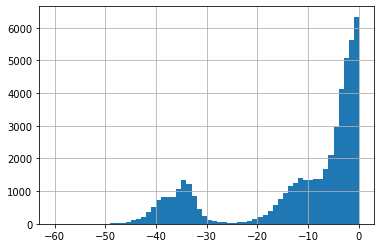

In [80]:
maybe_missing['merge_minus_smooth'].hist(bins=60, range=(-60, 0))

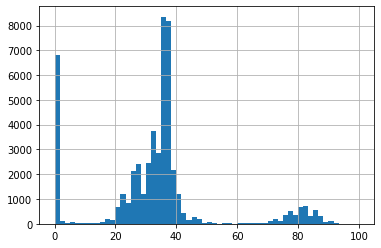

In [84]:
maybe_missing['merging_total-votes'].hist(bins=60, range=(0, 100))

In [76]:
(maybe_missing['merging_total-votes'] == 0).mean()

0.13194362658501158

In [77]:
# final_df.to_parquet('current_final_dr5_result_without_metadata.parquet', index=False)

In [78]:
# final_df.to_csv('current_final_dr5_result_without_metadata.csv', index=False)